In [1]:
# File Directory 
import glob
import os
from os.path import isdir, join
from pathlib import Path

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
import librosa

# Dimension Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

# Data Pre-processing
import pandas as pd
from sklearn.model_selection import KFold

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, layers, optimizers, backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import re
from sklearn.preprocessing import LabelBinarizer
# Configuration
#py.init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
def show(data):
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr = 22050)

## Data extraction

In [ ]:
samples=[]
labels = []
gunshot_frequency_threshold = 0.25
sample_rate = 22050
sample_rate_per_two_seconds = 44100
input_shape = (sample_rate_per_two_seconds, 1)
base_dir = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\"
data_dir = base_dir + "REU_Samples_and_Labels\\"
sound_data_dir = data_dir + "Samples\\"

In [ ]:
sound_types = pd.read_csv(data_dir + "labels.csv")

In [ ]:
np.unique(sound_types.Class)

In [ ]:
print("...Parsing sound data...")
sound_file_id = 0
sound_file_names = []
count = 0

for file in os.listdir(sound_data_dir):
    if (count % 100 == 0):
        print(count)
        
    count += 1
    if file.endswith(".wav"):
        # Adding 2 second-long samples to the list of samples
        sound_file_id = int(re.search(r'\d+', file).group())
        sample, sample_rate = librosa.load(sound_data_dir + file, res_type='kaiser_fast')
        prescribed_label = sound_types.loc[sound_types["ID"] == sound_file_id, "Class"].values[0]
        label = prescribed_label

        if len(sample) <= sample_rate_per_two_seconds:
            number_of_missing_hertz = sample_rate_per_two_seconds - len(sample)
            padded_sample = np.array(sample.tolist() + [0 for i in range(number_of_missing_hertz)])
                
            samples.append(padded_sample)
            labels.append(label)
            sound_file_names.append(file)
        else:
            for i in range(0, sample.size - sample_rate_per_two_seconds, sample_rate_per_two_seconds):
                sample_slice = sample[i : i + sample_rate_per_two_seconds]

                samples.append(sample_slice)
                labels.append(label)
                sound_file_names.append(file)

print("The number of samples available for training is currently " + str(len(samples)) + '.')
print("The number of labels available for training is currently " + str(len(labels)) + '.')

In [ ]:
labels

In [ ]:
p = 7000
show(samples[p])
print(max(abs(samples[p])))
print(labels[p])
ipd.Audio(samples[p], rate=22050)


In [ ]:
np.unique(labels)

In [ ]:
np.save("samples.npy", samples)
np.save("labels.npy", labels)
np.save("file_names.npy", sound_file_names)

In [ ]:
samples = list(np.load("samples.npy"))
labels = list(np.load("labels.npy"))
sound_file_names = np.load("file_names.npy")

In [ ]:
old = len(samples)

## Add other data

In [ ]:
sound_data_dir = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\other\\"

In [ ]:
count = 0
for file in os.listdir(sound_data_dir):
    if (count % 100 == 0):
        print(count)
        
    count += 1
    # Adding 2 second-long samples to the list of samples
    sample, sample_rate = librosa.load(sound_data_dir + file, res_type='kaiser_fast')
    label = "other"

    if len(sample) <= sample_rate_per_two_seconds:
        number_of_missing_hertz = sample_rate_per_two_seconds - len(sample)
        padded_sample = np.array(sample.tolist() + [0 for i in range(number_of_missing_hertz)])

        samples.append(padded_sample)
        labels.append(label)
        #sound_file_names.append(file)
    else:
        for i in range(0, sample.size - sample_rate_per_two_seconds, sample_rate_per_two_seconds):
            sample_slice = sample[i : i + sample_rate_per_two_seconds]

            samples.append(sample_slice)
            labels.append(label)
            #sound_file_names.append(file)


In [ ]:
len(samples) - old

In [ ]:
np.save("samples.npy", samples)
np.save("labels.npy", labels)

In [ ]:
samples = np.load("samples.npy")
labels = np.load("labels.npy")

In [ ]:
np.unique(labels)

In [ ]:
labels1 = labels[labels != 'other']

In [ ]:
urban = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'jackhammer', 'siren', 'street_music']

In [ ]:
for i in range(len(labels1)):
    if labels1[i] in urban:
        labels1[i] = 'urban'

In [ ]:
np.unique(labels1)

## Augment data

In [ ]:
'''label_csv = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\REU_Samples_and_Labels\\labels.csv"
sound_directory = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\REU_Samples_and_Labels\\Samples\\"
sound_types = pd.read_csv(label_csv)
bg_files = os.listdir(sound_directory)
print(len(bg_files))

for file in os.listdir(sound_directory):
    if file.endswith(".wav"):
        sound_file_id = int(re.search(r'\d+', file).group())
        prescribed_label = sound_types.loc[sound_types["ID"] == sound_file_id, "Class"].values[0]
        
        if prescribed_label == "gun_shot":
            bg_files.remove(file)
            
print(len(bg_files))'''

In [ ]:
def time_shift(wav):
    start_ = int(np.random.uniform(-7000, 7000))
    if start_ >= 0:
        wav_time_shift = np.r_[wav[start_:], np.random.uniform(-0.001, 0.001, start_)]
    else:
        wav_time_shift = np.r_[np.random.uniform(-0.001, 0.001, -start_), wav[:start_]]
    return wav_time_shift
    
def change_pitch(wav, sample_rate):
    magnitude = (np.random.uniform(-0.1, 0.1))
    wav_pitch_change = librosa.effects.pitch_shift(wav, sample_rate, magnitude)
    return wav_pitch_change
    
def speed_change(wav):
    speed_rate = np.random.uniform(0.7, 1.3)
    wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
    
    if len(wav_speed_tune) < len(wav):
        pad_len = len(wav) - len(wav_speed_tune)
        wav_speed_tune = np.r_[np.random.uniform(-0.0001, 0.0001, int(pad_len / 2)),
                               wav_speed_tune,
                               np.random.uniform(-0.0001, 0.0001, int(np.ceil(pad_len / 2)))]
    else: 
        cut_len = len(wav_speed_tune) - len(wav)
        wav_speed_tune = wav_speed_tune[int(cut_len / 2) : int(cut_len / 2) + len(wav)]
    return wav_speed_tune
    
def change_volume(wav, magnitude):
    # 0 < x < 1 quieter; x = 1 identity; x > 1 louder
    wav_volume_change = np.multiply(np.array([magnitude]), wav)
    return wav_volume_change
    
def add_background(wav, bg_files):
    sound_directory = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\REU_Samples_and_Labels\\Samples\\"
    chosen_bg_file = bg_files[np.random.randint(len(bg_files))]

    bg, sr = librosa.load(sound_directory + chosen_bg_file, res_type='kaiser_fast')
    ceil = max((bg.shape[0] - wav.shape[0]), 1)
    start_ = np.random.randint(ceil)
    bg_slice = bg[start_ : start_ + wav.shape[0]]
    if bg_slice.shape[0] < wav.shape[0]:
        pad_len = wav.shape[0] - bg_slice.shape[0]
        bg_slice = np.r_[np.random.uniform(-0.001, 0.001, int(pad_len / 2)), bg_slice, np.random.uniform(-0.001, 0.001, int(np.ceil(pad_len / 2)))]
    wav_with_bg = wav * np.random.uniform(0.8, 1.2) + bg_slice * np.random.uniform(0, 0.5)
    return wav_with_bg

In [ ]:
number_of_augmentations = 4
augmented_samples = np.zeros((samples.shape[0] * (number_of_augmentations + 1), samples.shape[1]))
augmented_labels = np.zeros((labels.shape[0] * (number_of_augmentations + 1),)).astype('str')
j = 0

for i in range (0, len(augmented_samples), (number_of_augmentations + 1)):
    if i % 100 == 0:
        print(i)
    
    augmented_samples[i,:] = samples[j,:]
    augmented_samples[i + 1,:] = time_shift(samples[j,:])
    augmented_samples[i + 2,:] = change_pitch(samples[j,:], sample_rate)
    augmented_samples[i + 3,:] = speed_change(samples[j,:])
    augmented_samples[i + 4,:] = change_volume(samples[j,:], np.random.uniform())
    ''' if labels[j] == 1:
        augmented_samples[i + 5,:] = add_background(samples[j,:], bg_files) 
    else:
        augmented_samples[i + 5,:] = add_background(samples[j,:], bg_files)
        '''
    
    augmented_labels[i] = labels[j]
    augmented_labels[i + 1] = labels[j]
    augmented_labels[i + 2] = labels[j]
    augmented_labels[i + 3] = labels[j]
    augmented_labels[i + 4] = labels[j]
    #augmented_labels[i + 5] = labels[j]
    j += 1

print("The number of samples available for training is currently " + str(len(augmented_samples)) + '.')
print("The number of labels available for training is currently " + str(len(augmented_labels)) + '.')

In [ ]:
np.save("aug_samples.npy", augmented_samples)
np.save("aug_labels.npy", augmented_labels)

## Model

In [ ]:
from sklearn.preprocessing import LabelBinarizer
samples = np.load("samples.npy")
labels = np.load("labels.npy")

In [ ]:
np.unique(labels)

In [ ]:
samples.nbytes / (2**10)**3

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels

In [ ]:
kf = KFold(n_splits=3, shuffle=True)
'''samples = aug_samples #np.array(samples)
labels = aug_labels #np.array(labels)'''

#labels = keras.utils.to_categorical(labels, 2)
for train_index, test_index in kf.split(samples):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_wav, test_wav = samples[train_index], samples[test_index]
    train_label, test_label = labels[train_index], labels[test_index]
    break

In [ ]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 32
drop_out_rate = 0.2
input_shape = (44100,1)

In [ ]:
#For Conv1D add Channel
#train_wav = np.array(train_wav)
#test_wav = np.array(test_wav)
train_wav = train_wav.reshape(-1,44100,1)
test_wav = test_wav.reshape(-1,44100,1)
#train_label = keras.utils.to_categorical(train_label, 2)
#test_label = keras.utils.to_categorical(test_label, 2)

### ROC AUC metric used.

In [3]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [4]:
drop_out_rate = 0.1
learning_rate = 0.001
number_of_epochs = 100
number_of_classes = 2
batch_size = 32
optimizer = optimizers.Adam(learning_rate, learning_rate / 100)
input_shape = (44100, 1)
input_tensor = Input(shape=input_shape)
metrics = [auc, "accuracy"]

x = layers.Conv1D(16, 9, activation="relu", padding="same")(input_tensor)
x = layers.Conv1D(16, 9, activation="relu", padding="same")(x)
x = layers.MaxPool1D(16)(x)
x = layers.Dropout(rate=drop_out_rate)(x)

x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPool1D(4)(x)
x = layers.Dropout(rate=drop_out_rate)(x)

x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPool1D(4)(x)
x = layers.Dropout(rate=drop_out_rate)(x)

x = layers.Conv1D(256, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(256, 3, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(rate=(drop_out_rate * 2))(x) # Increasing drop-out rate here to prevent overfitting

x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1028, activation="relu")(x)
output_tensor = layers.Dense(number_of_classes, activation="softmax")(x)

model = tf.keras.Model(input_tensor, output_tensor)
model.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=metrics)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
model.summary()

In [5]:
model_filename = "gunshot_sound_model.pkl"

model_callbacks = [
    EarlyStopping(monitor='val_acc',
                  patience=10,
                  verbose=1,
                  mode='auto'),
    
    ModelCheckpoint(model_filename, monitor='val_acc',
                    verbose=1,
                    save_best_only=True,
                    mode='auto'),
]


In [ ]:
model.fit(train_wav, train_label, 
          validation_data=[test_wav, test_label],
          batch_size=batch_size,
          callbacks = callbacks,
          epochs=50,
          verbose=1)

In [6]:
model.load_weights("gunshot_sound_model_normalized.h5")

### Validation

In [ ]:
mypath = "C:\\Users\\hosle\\Downloads\\felix_blume_fireworks_distant_new_years_eve_mexico.mp3"
#mypath = "C:\\Users\\hosle\\Documents\\_REU2019\\extra\\260600.wav"

fire, sr = librosa.load(mypath, res_type='kaiser_fast')

In [ ]:
show(fire)

In [53]:
labels = np.load("labels.npy")
urban = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'other',
       'drilling', 'engine_idling', 'jackhammer', 'siren', 'street_music', 'fireworks', 'glassbreak']
for i in range(len(labels)):
    if labels[i] in urban:
        labels[i] = 'other'

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np.hstack((labels, 1 - labels))

In [57]:
samples = np.load("valid_wav.npy")
labels = np.load("valid_label.npy")

In [48]:
labels

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [54]:
samples = samples.reshape(-1, 44100, 1)

val_pred = model.predict(samples)
val_pred1 = lb.inverse_transform(val_pred[:, 0])
print(len(val_pred1))
print("gun_shot", np.argwhere(val_pred1 == 'gun_shot').T)
print(val_pred1)

4045
gun_shot [[  58   81   92  124  152  167  168  218  228  248  253  267  313  337
   338  392  411  417  425  436  445  451  582  611  624  631  632  636
   677  685  687  688  699  722  723  760  784  811  903  918  926  944
   946  988 1057 1058 1079 1080 1086 1164 1195 1199 1211 1228 1250 1266
  1272 1359 1386 1387 1389 1427 1458 1623 1624 1625 1694 1740 1741 1767
  1800 1816 1892 1893 1903 1904 1905 1971 2017 2044 2046 2140 2166 2191
  2337 2338 2366 2367 2382 2397 2398 2405 2439 2440 2507 2583 2614 2632
  2661 2665 2666 2667 2683 2707 2782 2793 2794 2832 2865 2929 2932 3128
  3152 3153 3154 3155 3156 3158 3159 3160 3161 3162 3163 3164 3165 3166
  3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
  3181 3182 3183 3185 3187 3188 3189 3190 3191 3192 3193 3195 3196 3199
  3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213
  3214 3215 3216 3217 3218 3219 3221 3222 3223 3224 3225 3226 3227 3228
  3230 3231 3232 3233 3236 3237 3238 3239 3240 324

In [91]:
truth = lb.inverse_transform(labels[:,0])
arg = np.argwhere(truth != val_pred1)
print(len(arg))
print(arg.T)
print(1 - len(np.argwhere(truth != val_pred1)) / len(truth))

38
[[  62  200  227  356  943  945 1359 1427 1826 1970 2190 2312 2758 3128
  3184 3198 3220 3229 3235 3274 3295 3307 3347 3436 3494 3496 3506 3507
  3508 3509 3527 3528 3535 3552 3581 3595 3596 3598]]
0.9906056860321384


In [60]:
validation = np.load("valid_wav.npy")

[0.624 0.376]
predicted:  other
Truth:  gun_shot


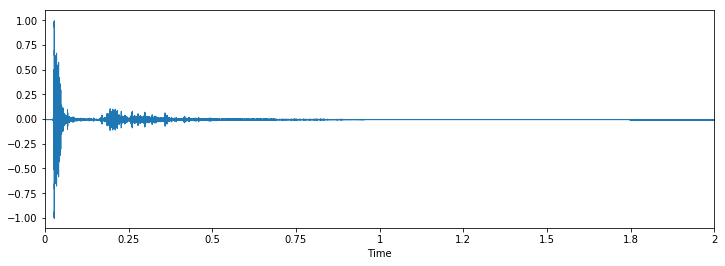

In [110]:
i = arg[33][0]
print(np.round(val_pred[i, :], 3))
print("predicted: ",val_pred1[i]); print("Truth: ", truth[i])
show(validation [i])

ipd.Audio(validation [i], rate=22050)

## Tflite converter

In [ ]:
model_name = "model.h5";

In [ ]:
converter = tf.contrib.lite.TFLiteConverter.from_keras_model_file(model_name)# custom_objects={'auc': auc})
print("\n made the converter using from_keras_model \n")

In [ ]:
#post-training quantization
converter.post_training_quantize = True
print(" did post training quantization \n")

In [ ]:
#convert
tflite_model = converter.convert()
print(" converted successfully \n")

In [ ]:
#save
open("converted_gunshot_model_ptq.tflite", "wb").write(tflite_model)
print(" saved successfully \n")